In [40]:
%reset

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [42]:
df_btc = pd.read_csv('../data/btc-usd-max.csv')
df_ir = pd.read_csv('../data/10year_real_interest_rate.csv')
df_gdp = pd.read_csv('../data/us_gdp_t.txt')
df_inflation = pd.read_csv('../data/us_inflation_rate.txt')

## Data preprocessing

In [43]:
df_btc = df_btc[(df_btc['snapped_at'] >= '2019-12-31') & (df_btc['snapped_at'] <= '2024-01-01')]
df_ir = df_ir[(df_ir['DATE'] >= '2020-01-01') & (df_ir['DATE'] <= '2024-01-01')]
df_gdp = df_gdp[df_gdp['Date'] >= '2019-12-31']
df_inflation = df_inflation[df_inflation['Date'] >= '2019-12-31']

In [44]:
df_btc['snapped_at'] = pd.to_datetime(df_btc['snapped_at']).dt.tz_localize(None)
df_btc.columns = ['date', 'btc_price', 'btc_market_cap', 'btc_volume_24hr']
df_btc.dtypes

date               datetime64[ns]
btc_price                 float64
btc_market_cap            float64
btc_volume_24hr           float64
dtype: object

In [45]:
df_btc['btc_supply'] = df_btc['btc_market_cap'] / df_btc['btc_price']
df_btc.drop(['btc_market_cap'], axis=1, inplace=True)

In [46]:
df_btc.set_index('date', inplace=True)
weekly_spread = df_btc['btc_price'].resample('W').apply(lambda x: x.max() - x.min())
df_btc['btc_weekly_spread'] = df_btc.index.to_series().map(weekly_spread)
df_btc.reset_index(inplace=True)

In [47]:
df_ir['DATE'] = pd.to_datetime(df_ir['DATE'])
df_ir.columns = ['date', 'us_real_interest_rate_percent']
df_ir.dtypes

date                             datetime64[ns]
us_real_interest_rate_percent           float64
dtype: object

In [48]:
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'])
df_gdp['Value'] = df_gdp['Value'].str.rstrip('T').astype(float)
df_gdp['Value'] = df_gdp['Value'] * 1e12
df_gdp.columns = ['date', 'us_gdp_usd']
df_gdp.dtypes

date          datetime64[ns]
us_gdp_usd           float64
dtype: object

In [49]:
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])
df_inflation.columns = ['date', 'us_inflation_rate_percent']
df_inflation.dtypes

date                         datetime64[ns]
us_inflation_rate_percent           float64
dtype: object

## Merge dataframes

In [50]:
df_btc_weekly = df_btc.set_index('date')
df_btc_weekly = df_btc_weekly.resample('W').mean()
df_btc_weekly.reset_index(inplace=True)
df_btc_weekly.head(10)

,date,btc_price,btc_volume_24hr,btc_supply,btc_weekly_spread
0,2020-01-05,7207.485803,2.226211e+10,1.814566e+07,387.523699
1,2020-01-12,7900.463817,3.163291e+10,1.812270e+07,830.540922
2,2020-01-19,8633.594520,3.913943e+10,1.815467e+07,796.254711
3,2020-01-26,8558.372633,2.991802e+10,1.817600e+07,376.152958
4,2020-02-02,9179.121879,4.520534e+10,1.818911e+07,914.076837
5,2020-02-09,9550.608454,6.358609e+10,1.820205e+07,710.742377
6,2020-02-16,10147.125407,5.710329e+10,1.821032e+07,438.776342
7,2020-02-23,9765.613191,4.569227e+10,1.822225e+07,525.648236
8,2020-03-01,9116.596085,4.041274e+10,1.823555e+07,1393.727005
9,2020-03-08,8866.565895,4.536157e+10,1.824718e+07,568.042817


In [51]:
df_btc_weekly['year_month'] = df_btc_weekly['date'].dt.to_period('M')
df_ir['year_month'] = df_ir['date'].dt.to_period('M')
df_gdp['year_month'] = df_gdp['date'].dt.to_period('M')
df_inflation['year_month'] = df_inflation['date'].dt.to_period('M')

df_week = pd.merge(df_btc_weekly, df_ir.drop(['date'], axis=1), on='year_month', how='left')
df_week = pd.merge(df_week, df_gdp.drop(['date'], axis=1), on='year_month', how='left')
df_week = pd.merge(df_week, df_inflation.drop(['date'], axis=1), on='year_month', how='left')
df_week.drop(['year_month'], axis=1, inplace=True)
df_week.reset_index()
df_week.head(10)

,date,btc_price,btc_volume_24hr,btc_supply,btc_weekly_spread,us_real_interest_rate_percent,us_gdp_usd,us_inflation_rate_percent
0,2020-01-05,7207.485803,2.226211e+10,1.814566e+07,387.523699,0.505096,2.202000e+13,2.49
1,2020-01-12,7900.463817,3.163291e+10,1.812270e+07,830.540922,0.505096,2.202000e+13,2.49
2,2020-01-19,8633.594520,3.913943e+10,1.815467e+07,796.254711,0.505096,2.202000e+13,2.49
3,2020-01-26,8558.372633,2.991802e+10,1.817600e+07,376.152958,0.505096,2.202000e+13,2.49
4,2020-02-02,9179.121879,4.520534e+10,1.818911e+07,914.076837,0.315986,2.212000e+13,2.33
5,2020-02-09,9550.608454,6.358609e+10,1.820205e+07,710.742377,0.315986,2.212000e+13,2.33
6,2020-02-16,10147.125407,5.710329e+10,1.821032e+07,438.776342,0.315986,2.212000e+13,2.33
7,2020-02-23,9765.613191,4.569227e+10,1.822225e+07,525.648236,0.315986,2.212000e+13,2.33
8,2020-03-01,9116.596085,4.041274e+10,1.823555e+07,1393.727005,-0.127837,2.098000e+13,1.54
9,2020-03-08,8866.565895,4.536157e+10,1.824718e+07,568.042817,-0.127837,2.098000e+13,1.54


## Data analysis

In [52]:
df_week['btc_price_log'] = np.log(df_week['btc_price'])

In [53]:
df_week.describe()

,date,btc_price,btc_volume_24hr,btc_supply,btc_weekly_spread,us_real_interest_rate_percent,us_gdp_usd,us_inflation_rate_percent,btc_price_log
count,209,209.000000,2.090000e+02,2.090000e+02,209.000000,209.000000,2.040000e+02,209.000000,209.000000
mean,2022-01-02 00:00:00,28854.401414,3.111875e+10,1.891018e+07,2736.384681,0.644989,2.441809e+13,4.512153,10.106360
min,2020-01-05 00:00:00,5672.529461,6.835211e+09,1.812270e+07,159.287956,-0.407134,1.894000e+13,0.120000,8.643390
25%,2021-01-03 00:00:00,17081.493461,2.105732e+10,1.857830e+07,804.256160,-0.127837,2.213000e+13,1.680000,9.745751
50%,2022-01-02 00:00:00,27452.272518,2.726968e+10,1.890195e+07,1936.342256,0.319495,2.486000e+13,4.930000,10.220204
75%,2023-01-01 00:00:00,40280.008736,3.680622e+10,1.924111e+07,4075.141938,1.443914,2.648000e+13,6.810000,10.603611
max,2023-12-31 00:00:00,65296.386220,8.705860e+10,1.958847e+07,11433.023989,2.094329,2.783000e+13,9.060000,11.086692
std,NaN,15132.297724,1.559971e+10,3.946303e+05,2415.724384,0.824345,2.348738e+12,2.678997,0.610329


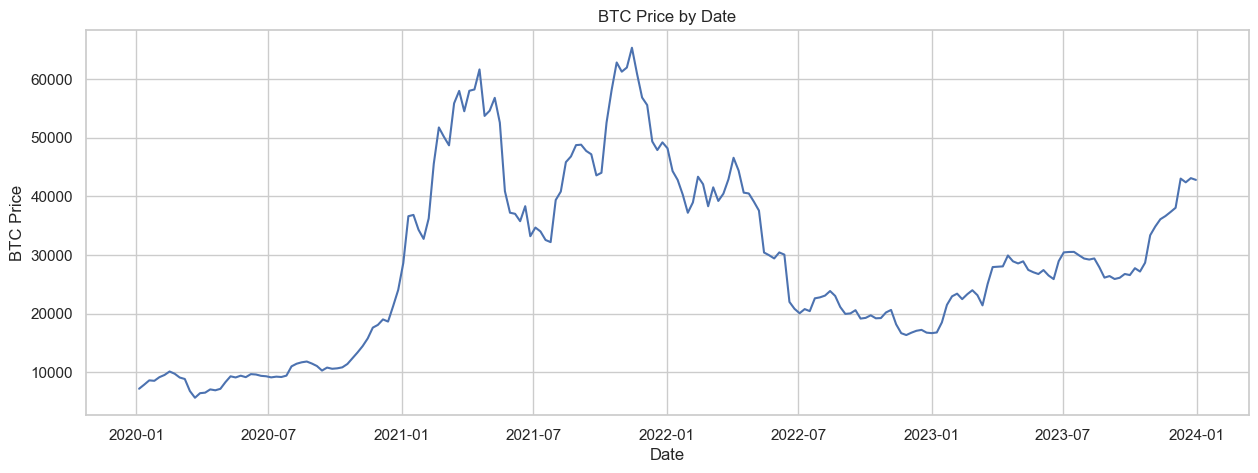

In [54]:
# Linechart of btc price by date
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_week['date'], df_week['btc_price'])
ax.set_xlabel('Date')
ax.set_ylabel('BTC Price')
ax.set_title('BTC Price by Date')
plt.show()

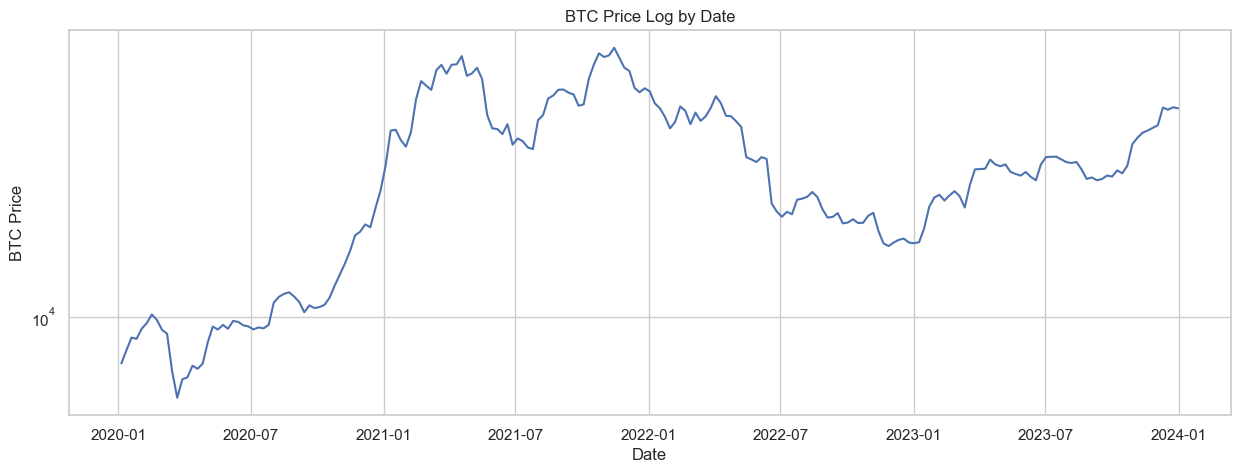

In [55]:
# Linechart of btc price by date in log scale
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_week['date'], df_week['btc_price'])
ax.set_xlabel('Date')
ax.set_ylabel('BTC Price')
ax.set_title('BTC Price Log by Date')
ax.set_yscale('log')
plt.show()

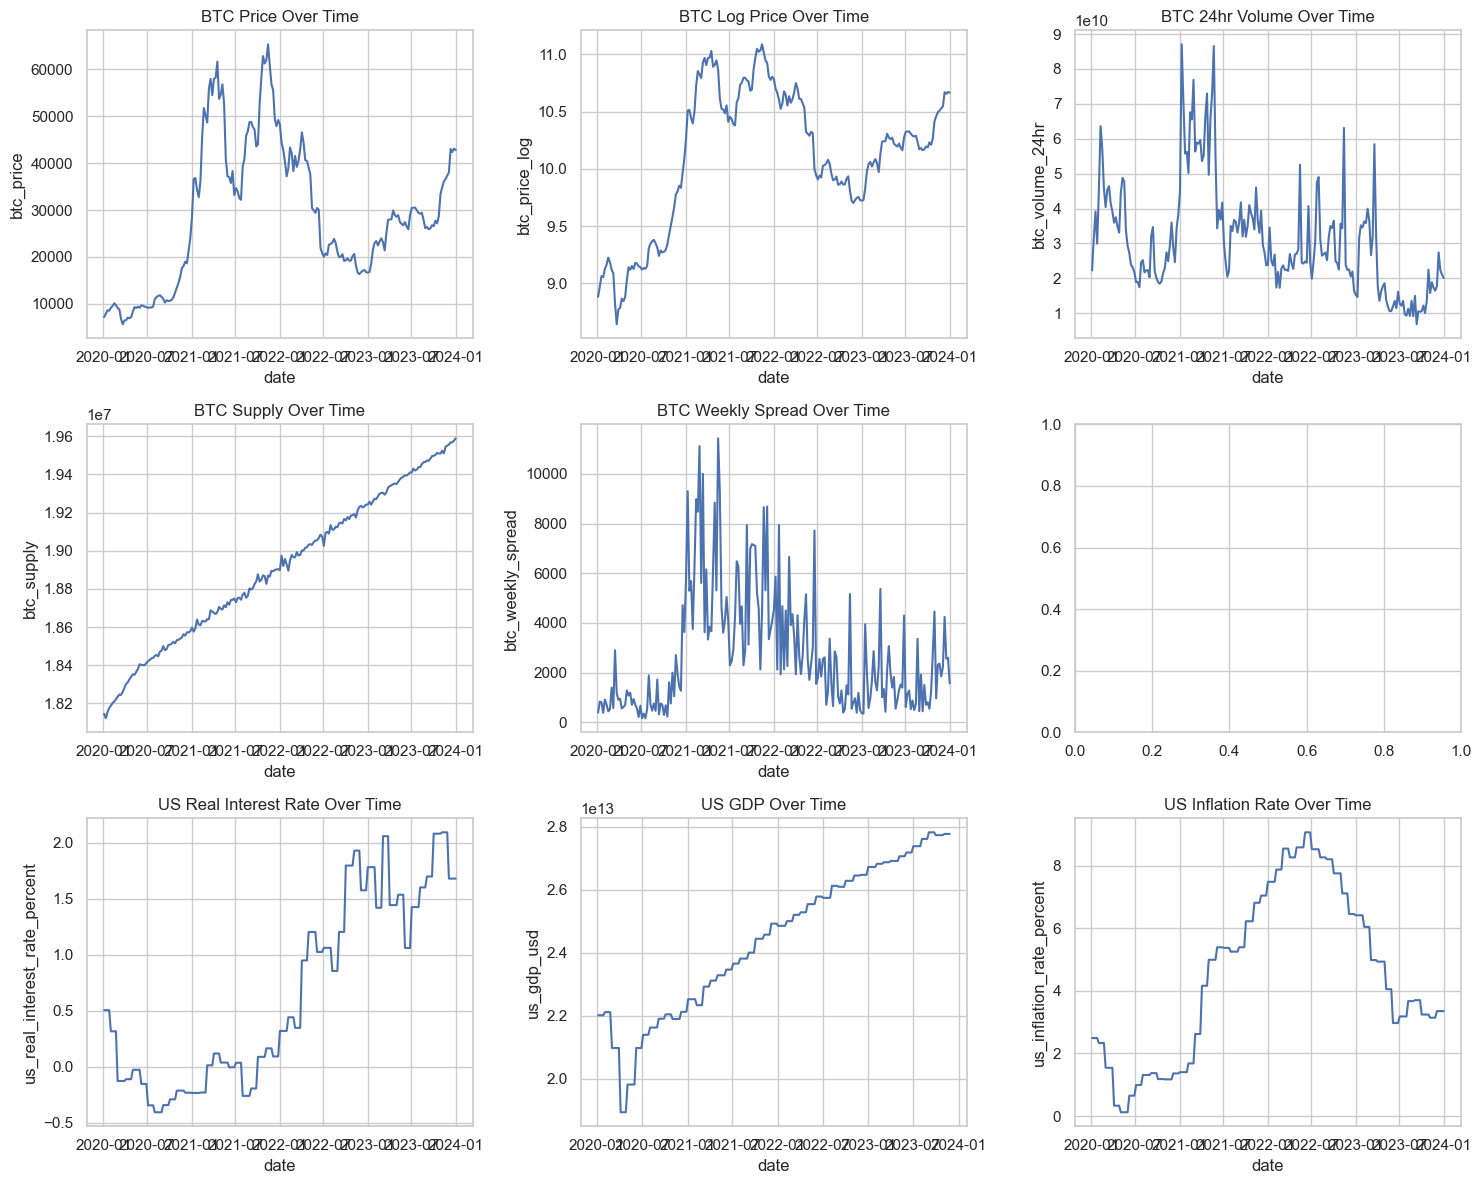

In [60]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Plot BTC Price
sns.lineplot(x='date', y='btc_price', data=df_week, ax=axes[0, 0])
axes[0, 0].set_title('BTC Price Over Time')

# Plot BTC Log Price
sns.lineplot(x='date', y='btc_price_log', data=df_week, ax=axes[0, 1])
axes[0, 1].set_title('BTC Log Price Over Time')

# Plot BTC 24hr Volume
sns.lineplot(x='date', y='btc_volume_24hr', data=df_week, ax=axes[0, 2])
axes[0, 2].set_title('BTC 24hr Volume Over Time')

# Plot BTC Supply
sns.lineplot(x='date', y='btc_supply', data=df_week, ax=axes[1, 0])
axes[1, 0].set_title('BTC Supply Over Time')

# Plot BTC Weekly Spread
sns.lineplot(x='date', y='btc_weekly_spread', data=df_week, ax=axes[1, 1])
axes[1, 1].set_title('BTC Weekly Spread Over Time')

# Plot US Real Interest Rate
sns.lineplot(x='date', y='us_real_interest_rate_percent', data=df_week, ax=axes[2, 0])
axes[2, 0].set_title('US Real Interest Rate Over Time')

# Plot US GDP
sns.lineplot(x='date', y='us_gdp_usd', data=df_week, ax=axes[2, 1])
axes[2, 1].set_title('US GDP Over Time')

# Plot US Inflation Rate
sns.lineplot(x='date', y='us_inflation_rate_percent', data=df_week, ax=axes[2, 2])
axes[2, 2].set_title('US Inflation Rate Over Time')

# Adjust layout
plt.tight_layout()
plt.show()


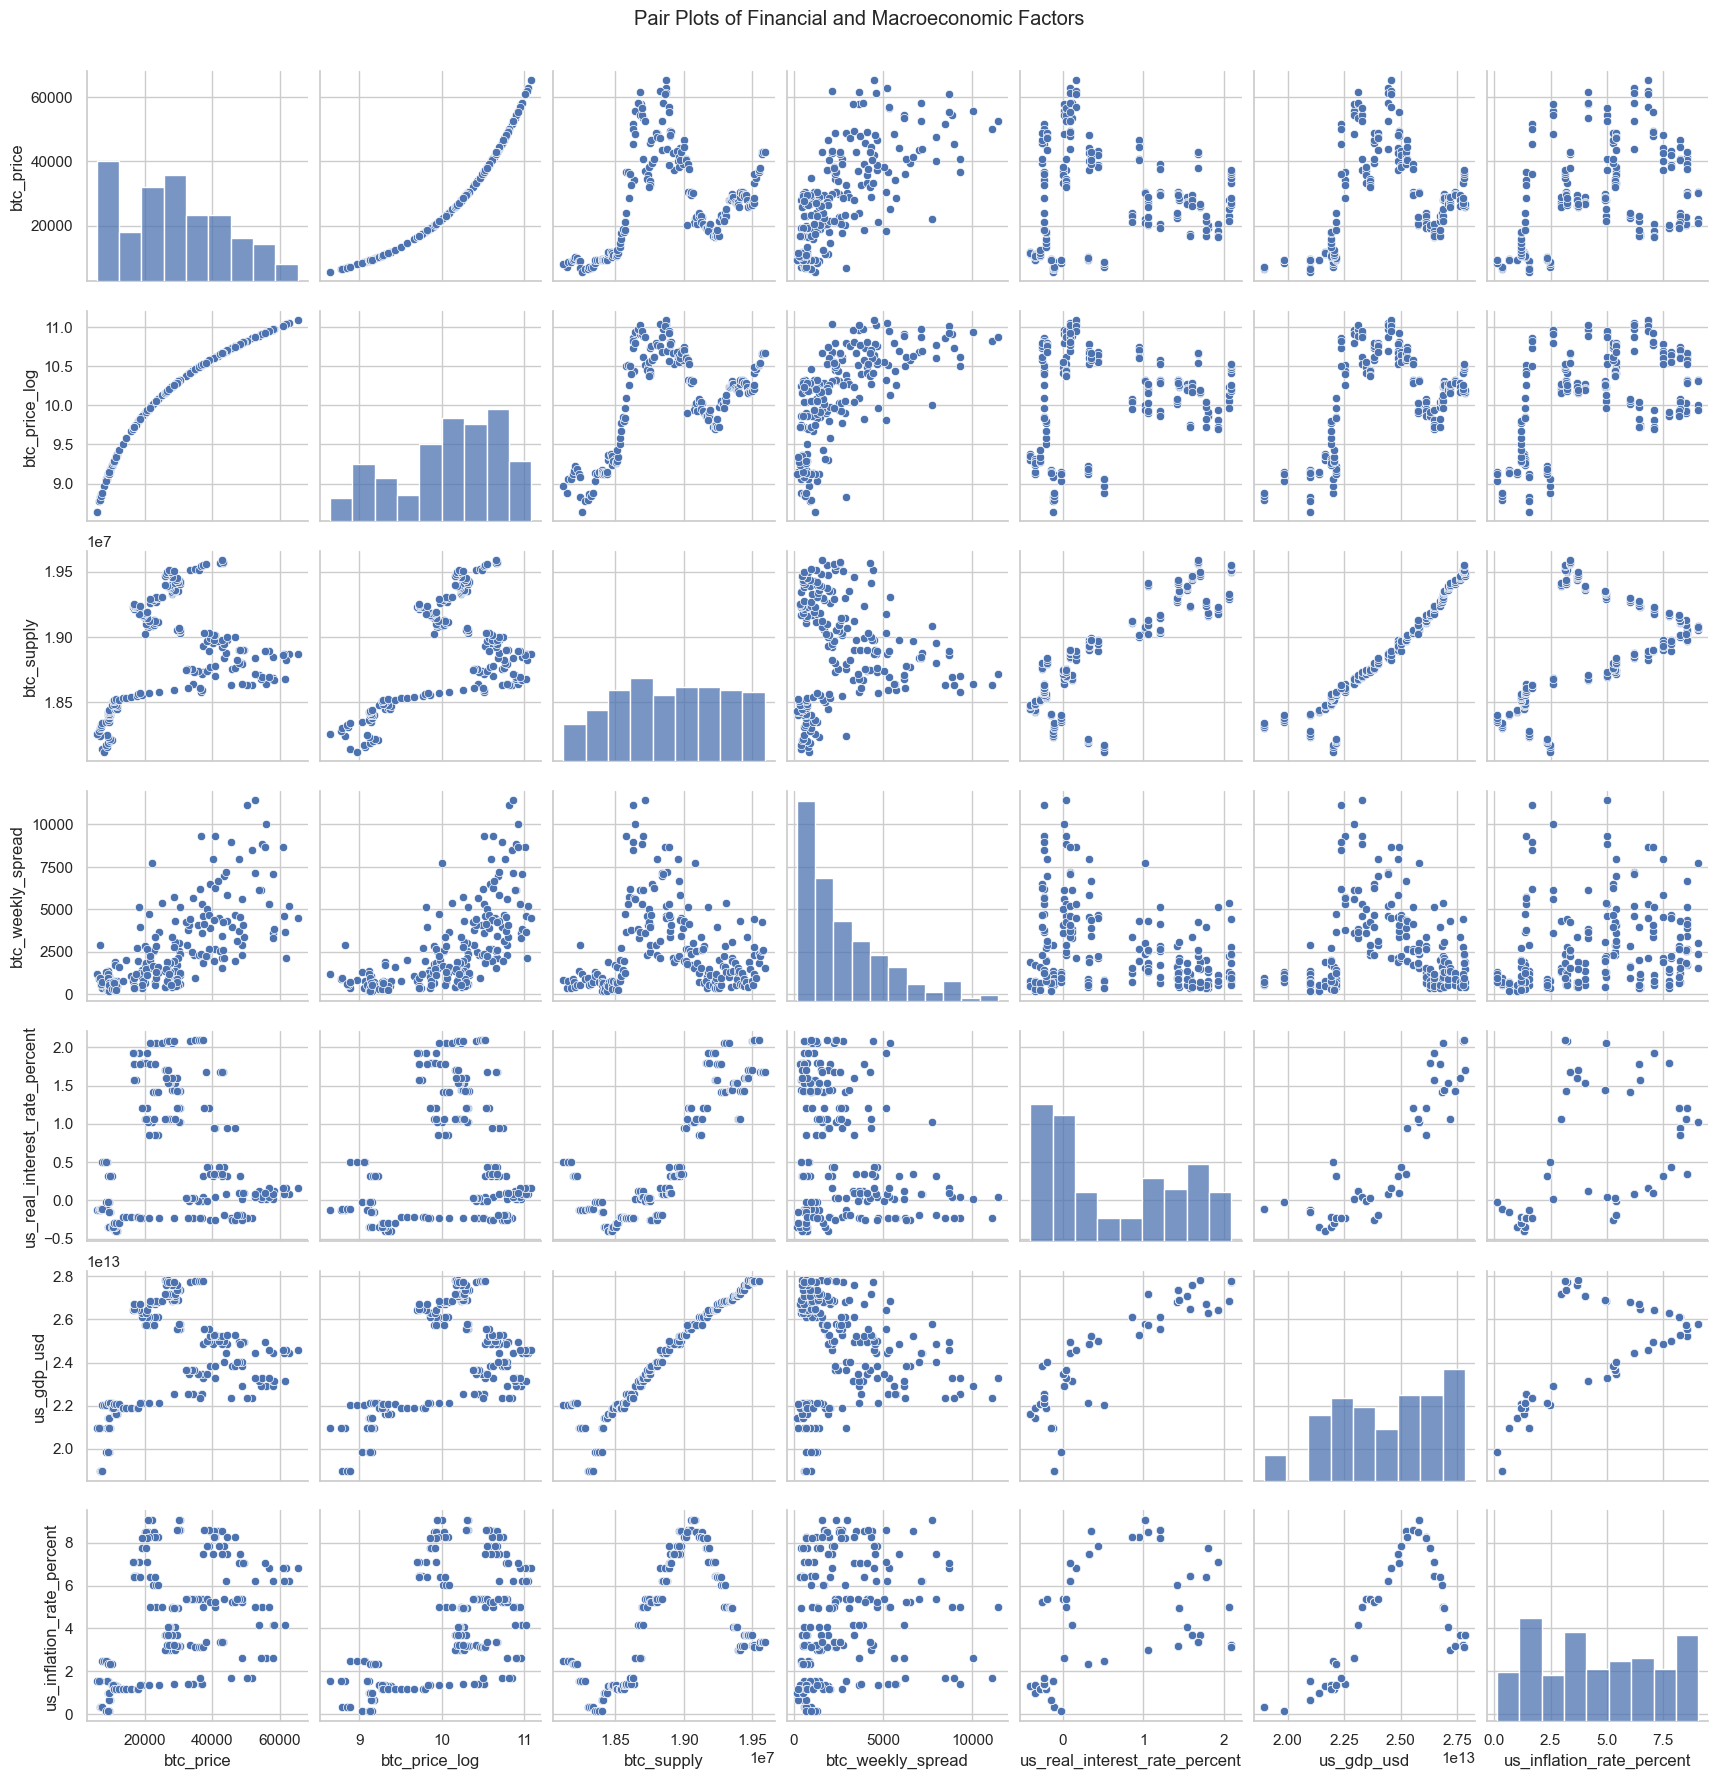

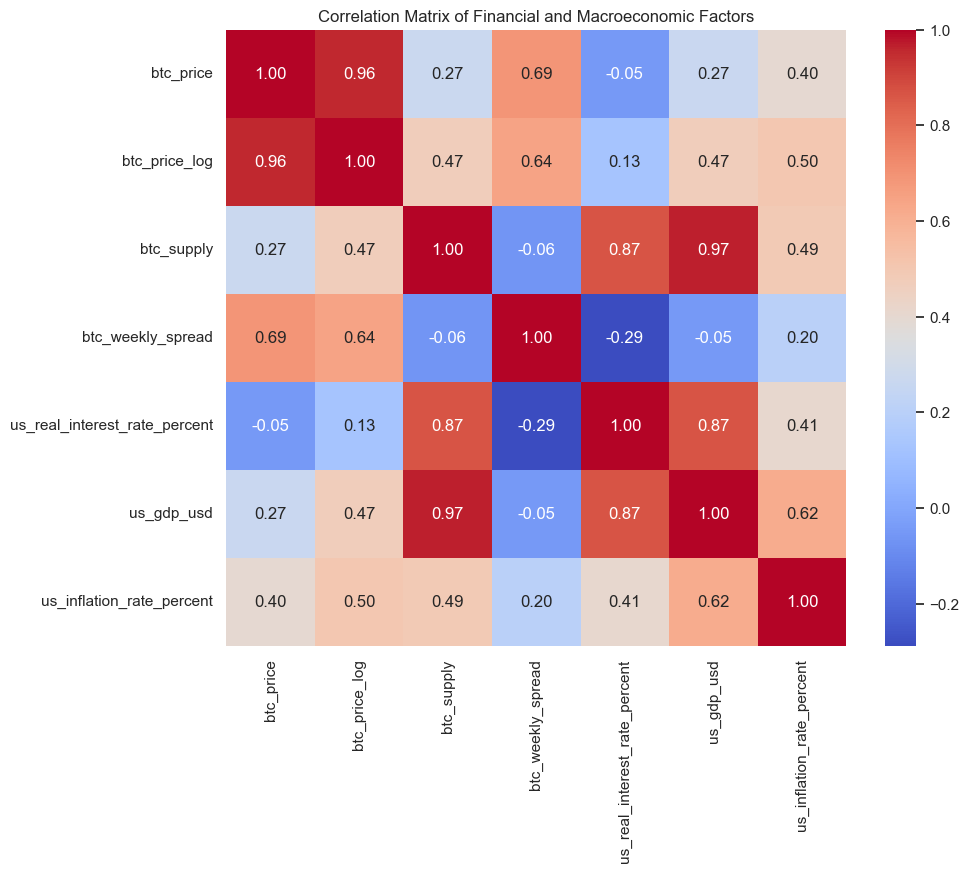

In [59]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create pair plots to visualize relationships
sns.pairplot(df_week[['btc_price', 'btc_price_log', 'btc_supply', 'btc_weekly_spread', 'us_real_interest_rate_percent', 'us_gdp_usd', 'us_inflation_rate_percent']])
plt.suptitle('Pair Plots of Financial and Macroeconomic Factors', y=1.02)
plt.show()

# Calculate and visualize correlation matrix
correlation_matrix = df_week[['btc_price', 'btc_price_log', 'btc_supply', 'btc_weekly_spread', 'us_real_interest_rate_percent', 'us_gdp_usd', 'us_inflation_rate_percent']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix of Financial and Macroeconomic Factors')
plt.show()
